In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
from PIL import Image
import time
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# Procesar Imagen (Automatización 1 Paso Proceso IGMS)

In [3]:
def procesar_imagen(ruta_imagen):
    """
    Procesa una imagen desde la ruta dada, manejando la orientación EXIF y devolviendo las máscaras generadas.
    """
    # Cargar la imagen con PIL para leer los metadatos EXIF
    image_pil = Image.open(ruta_imagen)

    # Obtener los metadatos EXIF
    try:
        exif = image_pil._getexif()
        if exif is not None:
            orientation = exif.get(274)  # 274 es el tag para orientación
        else:
            orientation = None
    except (AttributeError, KeyError, IndexError):
        orientation = None

    # Convertir la imagen de PIL a NumPy para OpenCV
    image_resized = cv2.imread(ruta_imagen)

    # Aplicar la rotación según la orientación EXIF
    print("Orientacion: ",orientation)
    if orientation == 3:  # 180 grados
        image_resized = cv2.rotate(image_resized, cv2.ROTATE_180)
    elif orientation == 6:  # 90 grados en sentido antihorario
        image_resized = cv2.rotate(image_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif orientation == 8:  # 270 grados en sentido antihorario
        image_resized = cv2.rotate(image_resized, cv2.ROTATE_90_CLOCKWISE)

    # Convertir la imagen a formato RGB para procesamiento
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Paso 2: Convertir a escala de grises
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Paso 3: Generar la máscara binaria M1 usando el método de Otsu
    _, mask_m1 = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Paso 4: Rellenar los agujeros en M1 para obtener M2
    contours, _ = cv2.findContours(mask_m1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_m2 = np.zeros_like(mask_m1)
    cv2.drawContours(mask_m2, contours, -1, (255), thickness=cv2.FILLED)

    # Paso 5: Separar los glóbulos blancos (WBCs) restando M1 de M2
    mask_wbcs = cv2.subtract(mask_m2, mask_m1)

    # Paso 6: Filtrar el ruido para obtener glóbulos blancos limpios
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask_clean_wbcs = cv2.morphologyEx(mask_wbcs, cv2.MORPH_OPEN, kernel)

    # Paso 7: Generar la máscara de parásitos
    mask_parasites_ = cv2.add(image_gray, mask_clean_wbcs)
    mask_parasites = cv2.add(mask_parasites_, cv2.bitwise_not(mask_m2))

    # Devolver los resultados
    return {
        "image_rgb": image_rgb,
        "image_gray": image_gray,
        "mask_m1": mask_m1,
        "mask_m2": mask_m2,
        "mask_wbcs": mask_wbcs,
        "mask_clean_wbcs": mask_clean_wbcs,
        "mask_parasites": mask_parasites,
        "ruta": ruta_imagen,
        "orientation": orientation  # Incluir la orientación detectada para referencia
    }


### Verificación de funcionamiento

Orientacion:  6


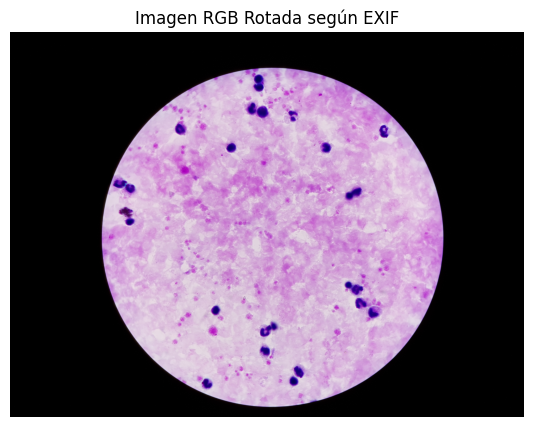

In [4]:
ruta_prueba = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes/TF1N_1522/20171023_110309.jpg"
resultados = procesar_imagen(ruta_prueba)

# Mostrar la imagen rotada
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Imagen RGB Rotada según EXIF")
plt.imshow(resultados["image_rgb"])
plt.axis("off")
plt.show()

In [5]:
'''# Paso 7: Preparar las visualizaciones en Matplotlib
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

titles = [
    "Imagen RGB Original", "Escala de Grises", "Máscara Binaria (M1)",
    "Máscara ROI (M2)", "Glóbulos Blancos (WBCs)", "WBCs Limpios"
]
images = [resultados["image_rgb"], resultados["image_gray"], resultados["mask_m1"], resultados["mask_m2"], resultados["mask_wbcs"], resultados["mask_clean_wbcs"]]

for ax, title, img in zip(axes, titles, images):
    if len(img.shape) == 2:  # Escala de grises o máscaras binarias
        ax.imshow(img, cmap="gray")
    else:  # Imagen RGB
        ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()'''


'# Paso 7: Preparar las visualizaciones en Matplotlib\nfig, axes = plt.subplots(3, 2, figsize=(15, 10))\naxes = axes.ravel()\n\ntitles = [\n    "Imagen RGB Original", "Escala de Grises", "Máscara Binaria (M1)",\n    "Máscara ROI (M2)", "Glóbulos Blancos (WBCs)", "WBCs Limpios"\n]\nimages = [resultados["image_rgb"], resultados["image_gray"], resultados["mask_m1"], resultados["mask_m2"], resultados["mask_wbcs"], resultados["mask_clean_wbcs"]]\n\nfor ax, title, img in zip(axes, titles, images):\n    if len(img.shape) == 2:  # Escala de grises o máscaras binarias\n        ax.imshow(img, cmap="gray")\n    else:  # Imagen RGB\n        ax.imshow(img)\n    ax.set_title(title)\n    ax.axis("off")\n\nplt.tight_layout()\nplt.show()'

# Elegir candidatos (Automatización 2 Paso Proceso IGMS)

In [6]:
def seleccionar_candidatos(mask_parasites, radio_parasito=27, num_candidatos=27, tiempo_limite=4):
    """
    Selecciona candidatos a parásitos desde una máscara binaria usando un proceso iterativo.

    Args:
        mask_parasites (np.ndarray): Máscara binaria donde buscar los candidatos.
        radio_parasito (int): Radio de las regiones de interés (ROIs) en píxeles.
        num_candidatos (int): Número máximo de candidatos a seleccionar.
        tiempo_limite (int): Tiempo límite en segundos para el proceso iterativo.

    Returns:
        list: Lista de coordenadas (x, y) de los candidatos seleccionados.
        np.ndarray: Máscara procesada con las regiones ignoradas marcadas.
    """
    # Crear una copia de la máscara para modificarla durante el proceso
    mask_to_process = mask_parasites.copy()
    candidates = []

    # Registrar el tiempo inicial
    inicio = time.time()

    # Proceso iterativo para seleccionar candidatos
    while len(candidates) < num_candidatos:
        # Encuentra el píxel con intensidad mínima en la máscara
        min_val, _, min_loc, _ = cv2.minMaxLoc(mask_to_process)

        # Verificar si se alcanzó el tiempo límite
        if time.time() - inicio > tiempo_limite:
            print(f"Se alcanzó el tiempo límite de {tiempo_limite} segundos.")
            break

        # Si ya no quedan píxeles válidos, romper el bucle
        if min_val == 255:  # No quedan píxeles negros en la máscara
            break

        # Validar que el candidato esté a suficiente distancia de los anteriores
        if all(
            np.sqrt((min_loc[0] - x) ** 2 + (min_loc[1] - y) ** 2) > radio_parasito
            for y, x in candidates
        ):
            candidates.append(min_loc)  # Agregar el candidato

            # Marcar la región como procesada (poner en blanco para ignorarla)
            cv2.circle(mask_to_process, min_loc, radio_parasito, (255), -1)

    return {
        "candidates": candidates,
        "mask_to_process": mask_to_process
    }

### Verificación de funcionamiento

In [7]:
ruta_prueba = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes/TF1N_1522/20171023_110309.jpg"
resultados = procesar_imagen(ruta_prueba)
resultados2 = seleccionar_candidatos(resultados['mask_parasites'])

Orientacion:  6


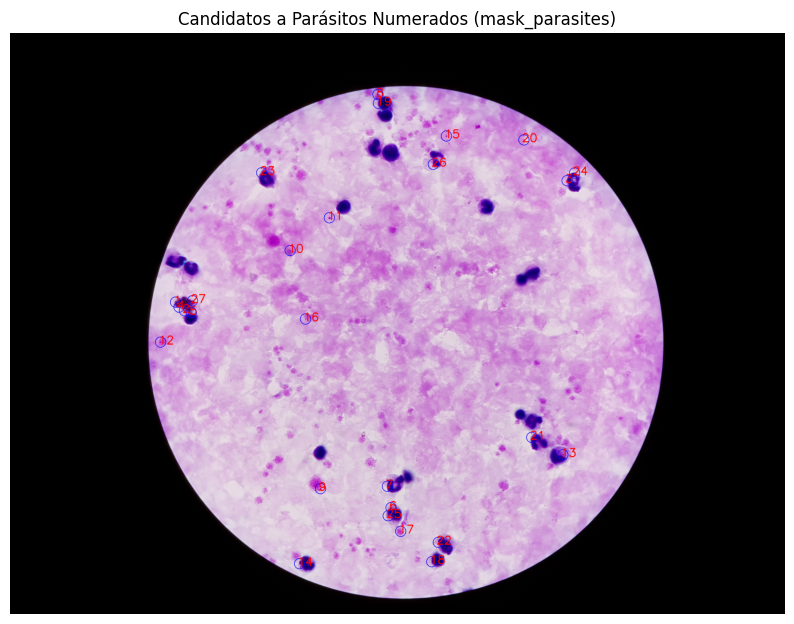

In [8]:
# Crear una copia de la máscara para modificarla durante el proceso
mask_parasites = resultados['mask_parasites'].copy()
image_rgb2 = resultados['image_rgb'].copy()
parasite_candidates = resultados2['candidates'].copy()

# Visualizar los resultados en `mask_parasites`
mask_with_circles = cv2.cvtColor(mask_parasites, cv2.COLOR_GRAY2BGR)  # Convertir a RGB para dibujar en color
for i, candidate in enumerate(parasite_candidates, start=1):
    # Dibujar círculos en rojo
    cv2.circle(image_rgb2, candidate, 27, (0, 0, 255), 2)
    # Agregar el número del candidato en azul
    cv2.putText(
        image_rgb2,
        str(i),
        (candidate[0] - 10, candidate[1] + 10),  # Ajustar la posición del texto
        cv2.FONT_HERSHEY_SIMPLEX,
        2,  # Tamaño de la fuente
        (255, 0, 0),  # Color del texto (azul)
        3,  # Grosor del texto
        cv2.LINE_AA,
    )

# Mostrar la máscara con los círculos y números
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb2)
plt.title("Candidatos a Parásitos Numerados (mask_parasites)")
plt.axis("off")
plt.show()

# Realizar Recortes (Automatización 3 Paso Proceso IGMS)

In [9]:
def generar_df_recortes(image, candidates, radio_parasito, factor_escala=1):
    """
    Genera un DataFrame con los recortes alrededor de los candidatos en una imagen.

    Args:
        image (np.ndarray): Imagen original (RGB) de donde se recortarán las regiones.
        candidates (list): Lista de coordenadas (x, y) de los candidatos.
        radio_parasito (int): Radio de las regiones de interés en píxeles.
        factor_escala (float): Factor para escalar el tamaño del recorte.

    Returns:
        pd.DataFrame: DataFrame con los recortes y sus metadatos.
    """
    # Crear un DataFrame vacío para almacenar los datos
    df_recortes = pd.DataFrame(columns=["id_recorte", "x_centro", "y_centro", "x_start", "x_end", "y_start", "y_end", "recorte"])

    # Escalar el radio del recorte
    radio_ajustado = int(radio_parasito * factor_escala)

    # Recortar cada candidato y agregar al DataFrame
    for i, (x, y) in enumerate(candidates, start=1):
        # Definir los límites del recorte considerando el radio ajustado
        x_start = max(x - radio_ajustado, 0)
        x_end = min(x + radio_ajustado, image.shape[1])
        y_start = max(y - radio_ajustado, 0)
        y_end = min(y + radio_ajustado, image.shape[0])

        # Realizar el recorte
        crop = image[y_start:y_end, x_start:x_end]

        # Agregar una fila al DataFrame
        df_recortes = pd.concat([
            df_recortes,
            pd.DataFrame({
                "id_recorte": [i],       # ID del recorte
                "x_centro": [x],         # Coordenada x del centro
                "y_centro": [y],         # Coordenada y del centro
                "x_start": [x_start],    # Límite izquierdo
                "x_end": [x_end],        # Límite derecho
                "y_start": [y_start],    # Límite superior
                "y_end": [y_end],        # Límite inferior
                "recorte": [crop],       # Imagen recortada (como matriz NumPy)
            })
        ], ignore_index=True)

    return df_recortes

## Verificación de funcionamiento

In [10]:
radio_parasito = 22

ruta_prueba = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes/TF1N_1522/20171023_110309.jpg"
resultados = procesar_imagen(ruta_prueba)
resultados2 = seleccionar_candidatos(resultados['mask_parasites'])
resultados_recortes = generar_df_recortes(resultados['image_rgb'],resultados2['candidates'],radio_parasito)
resultados_recortes

Orientacion:  6


,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte
0,1,861,1403,839,883,1381,1425,"[[[223, 200, 226], [223, 199, 225], [222, 198,..."
1,2,907,1447,885,929,1425,1469,"[[[119, 70, 151], [112, 63, 144], [111, 62, 14..."
2,3,2898,772,2876,2920,750,794,"[[[216, 165, 222], [217, 166, 223], [218, 167,..."
3,4,879,1429,857,901,1407,1451,"[[[184, 103, 180], [175, 85, 172], [182, 83, 1..."
4,5,943,1457,921,965,1435,1479,"[[[68, 8, 80], [68, 10, 84], [66, 8, 82], [64,..."
5,6,1982,2471,1960,2004,2449,2493,"[[[221, 207, 222], [219, 205, 220], [221, 204,..."
6,7,1963,2360,1941,1985,2338,2382,"[[[202, 160, 208], [204, 160, 209], [205, 161,..."
7,8,1914,324,1892,1936,302,346,"[[[172, 138, 214], [173, 139, 215], [170, 136,..."
8,9,1615,2372,1593,1637,2350,2394,"[[[183, 23, 195], [182, 25, 194], [186, 29, 19..."
9,10,1457,1135,1435,1479,1113,1157,"[[[194, 95, 203], [194, 95, 203], [195, 96, 20..."


In [11]:
'''import matplotlib.pyplot as plt

# Iterar sobre las filas del DataFrame y mostrar las imágenes
for index, row in resultados_recortes.iterrows():
    plt.figure(figsize=(4, 4))
    plt.imshow(row["recorte"])  # La columna 'recorte' contiene la imagen (matriz NumPy)
    plt.title(f"Recorte {row['id_recorte']} (Centro: {row['x_centro']}, {row['y_centro']})")
    plt.axis("off")
    plt.show()'''

'import matplotlib.pyplot as plt\n\n# Iterar sobre las filas del DataFrame y mostrar las imágenes\nfor index, row in resultados_recortes.iterrows():\n    plt.figure(figsize=(4, 4))\n    plt.imshow(row["recorte"])  # La columna \'recorte\' contiene la imagen (matriz NumPy)\n    plt.title(f"Recorte {row[\'id_recorte\']} (Centro: {row[\'x_centro\']}, {row[\'y_centro\']})")\n    plt.axis("off")\n    plt.show()'

In [12]:
'''for _, row in resultados_recortes.iterrows():  # Iterar por las filas del DataFrame
    plt.figure(figsize=(4, 4))
    plt.imshow(row['recorte'])  # Acceder a la columna 'recorte' (la imagen)
    plt.title(f"Recorte {row['id_recorte']} (Centro: {row['x_centro']}, {row['y_centro']})")
    plt.axis("off")
    plt.show()'''

'for _, row in resultados_recortes.iterrows():  # Iterar por las filas del DataFrame\n    plt.figure(figsize=(4, 4))\n    plt.imshow(row[\'recorte\'])  # Acceder a la columna \'recorte\' (la imagen)\n    plt.title(f"Recorte {row[\'id_recorte\']} (Centro: {row[\'x_centro\']}, {row[\'y_centro\']})")\n    plt.axis("off")\n    plt.show()'

# Procesar df

In [13]:
df_global = pd.DataFrame()

In [14]:

def procesar_anotaciones_y_recortes(ruta_notas, resultados_recortes, df_global):
    """
    Procesa las anotaciones de parásitos, realiza las comparaciones con los recortes,
    y agrega los datos procesados al DataFrame global.

    Args:
        ruta_notas (str): Ruta al archivo de anotaciones.
        resultados_recortes (pd.DataFrame): DataFrame con los recortes generados.
        df_global (pd.DataFrame): DataFrame global para consolidar resultados.

    Returns:
        pd.DataFrame: DataFrame global actualizado.
    """
    # Leer el archivo de anotaciones
    notas = pd.read_csv(ruta_notas, skiprows=1, header=None)

    # Asignar nombres a las columnas
    notas.columns = [
        'ID_nota', 'Type', 'Comment', 'Shape', 'Label',
        'X1', 'Y1', 'X2', 'Y2'
    ]

    # Filtrar solo las anotaciones de parásitos
    anotaciones_parasitos = notas[notas['Type'] == "Parasite"].copy()

    # Calcular el centro de las anotaciones
    anotaciones_parasitos['centro_x'] = (anotaciones_parasitos['X1'] + anotaciones_parasitos['X2']) / 2
    anotaciones_parasitos['centro_y'] = (anotaciones_parasitos['Y1'] + anotaciones_parasitos['Y2']) / 2

    # Comparar anotaciones con los recortes
    comparaciones = []
    for _, anotacion in anotaciones_parasitos.iterrows():
        x_annot, y_annot = anotacion["centro_x"], anotacion["centro_y"]
        id_nota = anotacion["ID_nota"]

        # Verificar si la anotación está dentro de algún recorte
        for _, recorte in resultados_recortes.iterrows():
            if (recorte["x_start"] <= x_annot <= recorte["x_end"] and
                recorte["y_start"] <= y_annot <= recorte["y_end"]):
                comparaciones.append({
                    "ID_nota": id_nota,
                    "id_recorte": recorte["id_recorte"],
                    "x_anotacion": x_annot,
                    "y_anotacion": y_annot,
                    "contiene_parasito": True
                })
                break

    # Convertir las comparaciones en un DataFrame
    df_comparaciones = pd.DataFrame(comparaciones)

    # Realizar el merge entre recortes y comparaciones
    df_final = pd.merge(resultados_recortes, df_comparaciones, on="id_recorte", how="left")

    # Crear la columna 'es_parasito'
    df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)
    df_final = df_final.drop(columns=["x_anotacion", "y_anotacion", "contiene_parasito"])

    # Extraer información del paciente e imagen usando regex
    pattern = r".*/([^/]+)/([^/]+)\.[^/]+$"
    match = re.match(pattern, ruta_notas)
    if match:
        penultimo_segmento = match.group(1)  # Paciente
        ultimo_segmento = match.group(2)     # Imagen
    else:
        penultimo_segmento, ultimo_segmento = None, None

    # Agregar columnas de paciente e imagen
    df_final["paciente"] = penultimo_segmento
    df_final["imagen"] = ultimo_segmento

    # Determinar si la imagen pertenece a la carpeta "Temporal" y asignar especie
    if "Falciparum" in ruta_notas:
        df_final["especie"] = 1
    else:
        df_final["especie"] = 0

    # Agregar los datos procesados al DataFrame global
    df_global = pd.concat([df_global, df_final], ignore_index=True)

    return df_global

## Verificación de funcionamiento

In [15]:
'''radio_parasito = 22

df_global = pd.DataFrame()
df_db = pd.DataFrame()

ruta_prueba = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes/TF1N_1522/20171023_110309.jpg"
ruta_notas= "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas/TF1N_1522/20171023_110309.txt"
resultados = procesar_imagen(ruta_prueba)
resultados2 = seleccionar_candidatos(resultados['mask_parasites'])
resultados_recortes = generar_df_recortes(resultados['image_rgb'],resultados2['candidates'],radio_parasito)
resultado_final = procesar_anotaciones_y_recortes(ruta_notas, resultados_recortes, df_global)

df_db = pd.concat([df_db,resultado_final],ignore_index=True)
df_db'''

'radio_parasito = 22\n\ndf_global = pd.DataFrame()\ndf_db = pd.DataFrame()\n\nruta_prueba = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes/TF1N_1522/20171023_110309.jpg"\nruta_notas= "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas/TF1N_1522/20171023_110309.txt"\nresultados = procesar_imagen(ruta_prueba)\nresultados2 = seleccionar_candidatos(resultados[\'mask_parasites\'])\nresultados_recortes = generar_df_recortes(resultados[\'image_rgb\'],resultados2[\'candidates\'],radio_parasito)\nresultado_final = procesar_anotaciones_y_recortes(ruta_notas, resultados_recortes, df_global)\n\ndf_db = pd.concat([df_db,resultado_final],ignore_index=True)\ndf_db'

# Funcionamiento final

In [16]:
import os
import numpy as np

def procesar_carpeta_principal_por_partes(carpeta_principal, df_db, radio_parasito=22, parte=1, total_partes=100):
    """
    Procesa una fracción de las imágenes y notas dentro de una carpeta principal ('Falciparum' o 'Vivax').

    Args:
        carpeta_principal (str): Ruta a la carpeta principal ('Falciparum' o 'Vivax').
        df_db (pd.DataFrame): DataFrame global para consolidar resultados.
        radio_parasito (int): Radio para las regiones de interés en píxeles.
        parte (int): Parte actual a procesar (1 para la primera mitad, 2 para la segunda, etc.).
        total_partes (int): Número total de partes en las que dividir el procesamiento.

    Returns:
        pd.DataFrame: DataFrame global actualizado con los datos procesados.
    """
    # Rutas específicas para imágenes y notas
    ruta_imagenes = os.path.join(carpeta_principal, "Imagenes")
    ruta_notas = os.path.join(carpeta_principal, "Notas")

    # Obtener las subcarpetas de pacientes
    subcarpetas_pacientes = sorted(os.listdir(ruta_imagenes))

    # Dividir las subcarpetas en partes iguales
    total_pacientes = len(subcarpetas_pacientes)
    pacientes_por_parte = np.array_split(subcarpetas_pacientes, total_partes)

    # Seleccionar la parte actual
    subcarpetas_a_procesar = pacientes_por_parte[parte - 1]  # Parte actual (1-indexed)

    # Iterar sobre las subcarpetas seleccionadas
    for carpeta_paciente in subcarpetas_a_procesar:
        carpeta_imagenes = os.path.join(ruta_imagenes, carpeta_paciente)
        carpeta_notas = os.path.join(ruta_notas, carpeta_paciente)

        # Verificar que existan ambas subcarpetas
        if not os.path.exists(carpeta_notas):
            print(f"No se encontró la carpeta de notas para: {carpeta_paciente}")
            continue

        # Crear un DataFrame global intermedio para esta iteración
        df_global = pd.DataFrame()

        # Procesar cada imagen en la subcarpeta de imágenes
        for archivo_imagen in os.listdir(carpeta_imagenes):
            if archivo_imagen.endswith(".jpg"):  # Filtrar solo imágenes
                ruta_imagen = os.path.join(carpeta_imagenes, archivo_imagen)

                # Construir la ruta correspondiente al archivo de notas
                nombre_base = os.path.splitext(archivo_imagen)[0]  # Nombre base (sin extensión)
                archivo_nota = f"{nombre_base}.txt"
                ruta_nota = os.path.join(carpeta_notas, archivo_nota)

                # Verificar si existe el archivo de notas correspondiente
                if not os.path.exists(ruta_nota):
                    print(f"No se encontró el archivo de notas para: {ruta_imagen}")
                    continue

                try:
                    # Procesar la imagen
                    print(f"Procesando imagen: {ruta_imagen}")
                    resultados = procesar_imagen(ruta_imagen)

                    # Seleccionar candidatos en la máscara de parásitos
                    resultados_candidatos = seleccionar_candidatos(resultados["mask_parasites"], radio_parasito=radio_parasito)

                    # Verificar si se encontraron candidatos
                    if not resultados_candidatos["candidates"]:
                        print(f"No se encontraron candidatos para: {ruta_imagen}")
                        continue

                    # Generar DataFrame de recortes
                    resultados_recortes = generar_df_recortes(
                        resultados["image_rgb"], resultados_candidatos["candidates"], radio_parasito
                    )

                    # Validar que el DataFrame de recortes no esté vacío
                    if resultados_recortes.empty:
                        print(f"El DataFrame de recortes está vacío para: {ruta_imagen}")
                        continue

                    # Procesar anotaciones y recortes
                    resultado_final = procesar_anotaciones_y_recortes(ruta_nota, resultados_recortes, df_global)

                    # Agregar el resultado al DataFrame global intermedio
                    df_global = pd.concat([df_global, resultado_final], ignore_index=True)

                except Exception as e:
                    print(f"Error al procesar la imagen {ruta_imagen}: {e}")

        # Agregar los datos procesados de esta iteración al DataFrame final
        df_db = pd.concat([df_db, df_global], ignore_index=True)

    return df_db

In [33]:
# Procesar la carpeta Falciparum en 3 partes
carpeta_falciparum = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum"
df_db = pd.DataFrame()

# Procesar la primera parte
print("Procesando la primera parte de Falciparum...")
df_db_parte1 = procesar_carpeta_principal_por_partes(carpeta_falciparum, pd.DataFrame(), radio_parasito=22, parte=1, total_partes=100)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("Guardando")
df_db_parte1.to_pickle('/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Primer avance/ImagenesProcesadas/falciparum_parte1.pkl')
#df_db_parte1.to_csv("/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Primer avance/ImagenesProcesadas/falciparum_parte1.csv", index=False,sep = ';')

Procesando la primera parte de Falciparum...
Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210416.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205620.jpg
Orientacion:  6
Se alcanzó el tiempo límite de 4 segundos.
Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210050.jpg


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205809.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205944.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205527.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205107.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210528.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210213.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_205324.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210634.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210950.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210830.jpg
Orientacion:  6
Se alcanzó el tiempo límite de 4 segundos.
Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210733.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)
<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_211104.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104957.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_105211.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_105037.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104521.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104418.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_105253.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104901.jpg
Orientacion:  6
Se alcanzó el tiempo límite de 4 segundos.
Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104736.jpg


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_105127.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104154.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104309.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_103930.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_105334.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


Procesando imagen: /content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF101_233/20170830_104641.jpg
Orientacion:  6


<ipython-input-14-a91fa44046a1>:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Guardando


In [32]:
df_db_parte1

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito,paciente,imagen,especie
0,1,1291,2408,1269,1313,2386,2430,"[[[235, 224, 241], [236, 228, 243], [234, 226,...",NaN,0,TF100_CS39,20170829_210416,1
1,2,2613,1441,2591,2635,1419,1463,"[[[178, 147, 206], [175, 144, 203], [174, 140,...",NaN,0,TF100_CS39,20170829_210416,1
2,3,2389,1099,2367,2411,1077,1121,"[[[209, 177, 214], [208, 176, 213], [207, 175,...",8-4,1,TF100_CS39,20170829_210416,1
3,4,2559,601,2537,2581,579,623,"[[[204, 164, 217], [205, 167, 218], [208, 170,...",8-1,1,TF100_CS39,20170829_210416,1
4,5,2328,1196,2306,2350,1174,1218,"[[[203, 171, 210], [199, 167, 206], [202, 167,...",8-5,1,TF100_CS39,20170829_210416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194617,23,2426,1630,2404,2448,1608,1652,"[[[113, 20, 197], [142, 50, 213], [173, 81, 22...",NaN,0,TF101_233,20170830_104641,1
1194618,24,1224,682,1202,1246,660,704,"[[[92, 3, 171], [91, 2, 170], [92, 1, 167], [9...",NaN,0,TF101_233,20170830_104641,1
1194619,25,1955,1058,1933,1977,1036,1080,"[[[223, 194, 225], [224, 195, 226], [224, 195,...",NaN,0,TF101_233,20170830_104641,1
1194620,26,2350,1589,2328,2372,1567,1611,"[[[227, 203, 229], [225, 201, 227], [227, 203,...",NaN,0,TF101_233,20170830_104641,1


In [30]:
df_db_parte1.iloc[2]

,2
id_recorte,3
x_centro,2389
y_centro,1099
x_start,2367
x_end,2411
y_start,1077
y_end,1121
recorte,"[[[209, 177, 214], [208, 176, 213], [207, 175,..."
ID_nota,8-4
es_parasito,1


array([[[209, 177, 214],
        [208, 176, 213],
        [207, 175, 212],
        ...,
        [225, 210, 233],
        [223, 212, 229],
        [222, 214, 227]],

       [[211, 179, 218],
        [207, 175, 212],
        [206, 174, 211],
        ...,
        [204, 181, 227],
        [212, 195, 231],
        [221, 208, 236]],

       [[209, 177, 216],
        [210, 178, 215],
        [209, 177, 214],
        ...,
        [180, 151, 218],
        [196, 172, 230],
        [213, 196, 240]],

       ...,

       [[216, 197, 219],
        [219, 197, 220],
        [220, 198, 221],
        ...,
        [234, 222, 234],
        [235, 223, 233],
        [236, 225, 233]],

       [[216, 197, 219],
        [217, 198, 220],
        [217, 198, 220],
        ...,
        [231, 214, 232],
        [236, 219, 235],
        [239, 223, 234]],

       [[216, 197, 219],
        [218, 199, 221],
        [219, 200, 222],
        ...,
        [223, 208, 227],
        [232, 215, 233],
        [239, 222, 238]]], dtype=uint8)
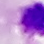

In [31]:
df_db_parte1['recorte'][2]

In [21]:
df.columns

Index(['id_recorte', 'x_centro', 'y_centro', 'x_start', 'x_end', 'y_start',
       'y_end', 'recorte', 'ID_nota', 'es_parasito', 'paciente', 'imagen',
       'especie'],
      dtype='object')

In [22]:
df[df['es_parasito']==1]

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito,paciente,imagen,especie
2,3,2389,1099,2367,2411,1077,1121,[[[209 177 214]\n [208 176 213]\n [207 175 2...,8-4,1,TF100_CS39,20170829_210416,1
3,4,2559,601,2537,2581,579,623,[[[204 164 217]\n [205 167 218]\n [208 170 2...,8-1,1,TF100_CS39,20170829_210416,1
4,5,2328,1196,2306,2350,1174,1218,[[[203 171 210]\n [199 167 206]\n [202 167 2...,8-5,1,TF100_CS39,20170829_210416,1
6,7,1901,1860,1879,1923,1838,1882,[[[221 204 222]\n [220 201 220]\n [218 199 2...,8-10,1,TF100_CS39,20170829_210416,1
10,11,1430,747,1408,1452,725,769,[[[220 197 223]\n [219 196 222]\n [219 195 2...,8-2,1,TF100_CS39,20170829_210416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528868,4,1546,1315,1524,1568,1293,1337,[[[221 200 219]\n [225 204 223]\n [225 206 2...,3-3,1,TF100_CS39,20170829_205620,1
528870,6,932,1029,910,954,1007,1051,[[[214 188 215]\n [217 191 218]\n [222 193 2...,3-5,1,TF100_CS39,20170829_205620,1
528871,7,2023,1562,2001,2045,1540,1584,[[[218 199 221]\n [221 202 222]\n [225 206 2...,3-6,1,TF100_CS39,20170829_205620,1
528877,2,2134,1568,2112,2156,1546,1590,[[[218 206 218]\n [218 206 218]\n [220 208 2...,6-1,1,TF100_CS39,20170829_210050,1


In [ ]:
'''# Procesar la segunda parte
print("Procesando la segunda parte de Falciparum...")
df_db_parte2 = procesar_carpeta_principal_por_partes(carpeta_falciparum, pd.DataFrame(), radio_parasito=22, parte=2, total_partes=12)
df_db_parte2.to_csv("falciparum_parte2.csv", index=False)

'''

In [ ]:
'''# Procesar la tercera parte
print("Procesando la tercera parte de Falciparum...")
df_db_parte3 = procesar_carpeta_principal_por_partes(carpeta_falciparum, pd.DataFrame(), radio_parasito=22, parte=3, total_partes=12)
df_db_parte3.to_csv("falciparum_parte3.csv", index=False)

'''

In [ ]:
'''# Consolidar todas las partes
df_db = pd.concat([df_db_parte1, df_db_parte2, df_db_parte3], ignore_index=True)
df_db.to_csv("falciparum_completo.csv", index=False)

print("Procesamiento completado.")'''